# Bayesion Filter
In this notebook, I will share bayesion filter with you, which is based for Kalman Filter.

[Preface]
Bayesion focus on current status which means it will not consider the past knowlege but only currency. Thus, you just focus on the currency and just like your life :)

In [1]:
%matplotlib inline
from __future__ import print_function
import matplotlib.pyplot as plt
import numpy as np

### Experiment Scenario
I love cat, and I want to track a cat named, Naroti.

First of all, imaging the environment contains 10 rooms, and three of these get door, and others are walls,  I want to estimate where is Naroti current position.

Secondly, I attach the sensor to her collar, and this sensor can detect door, wall, and moving right. After a while, sensor report Naroti is in front of the door, but there are three door, how I should know which one. Thus, I use probability to represent it and ready to estimate :)

In [2]:
hall_way = np.array([1, 1, 0, 0, 0, 0, 0, 0, 1, 0]).astype(np.float32)
belief = hall_way * (1./3)
belief

array([ 0.33333334,  0.33333334,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.33333334,  0.        ], dtype=float32)

However, perfect sensor are rare, so sensor will bring some noises to me.

In [3]:
belief = np.copy(hall_way)
belief[belief==0] = 0.1
belief[belief==1] = 0.3
belief = belief / sum(belief) # normalization
belief

array([ 0.1875,  0.1875,  0.0625,  0.0625,  0.0625,  0.0625,  0.0625,
        0.0625,  0.1875,  0.0625], dtype=float32)

It is a bit odd to say "3 times as likely to be right as wrong". As a analytist,  let's specify the probability of the sensor being correct.

Use this notation:
$$ scale=\frac{prob_{correct}}{prob_{incorrect}}=\frac{prob_{correct}}{1-prob_{correct}} $$

In [4]:
belief = np.array([0.1]*10)
belief[hall_way==1] *= .75 / (1.-.75)
belief = belief / sum(belief)
belief

array([ 0.1875,  0.1875,  0.0625,  0.0625,  0.0625,  0.0625,  0.0625,
        0.0625,  0.1875,  0.0625])

### Prediction

Due to sensor sometime get noise, I should consider this situation. Therefore,
I suppose sensor has 80% accuracy, 10% overshoot left, and 10% overshoot right.

If the measurement is 4, meaning 4 spaces to the right, that dog is 80% likely to have moved 4 spaces to the right, 10% to have moved 3 spaces, and 10% to have moved 5 spaces.

Let's use coding to represent it.

In [5]:
def predict_move(belief, move, p_under, p_correct, p_over):
    n = len(belief)
    prior = np.zeros(n)
    for i in range(n):
        prior[i] = (belief[(i-move)%n] * p_correct 
                    + belief[(i-move-1)%n] * p_over
                    + belief[(i-move+1)%n] * p_under)
    return prior

def simple_assumption_predict(belief):
    prior = predict_move(belief, 2, .1, .8, .1)
    
    ax = plt.subplot()
    ax.set_axisbelow(True)
    ax.grid()
    ax.bar(np.arange(10), prior)
    plt.show()

let's assume report is 100% accuracy, and we get the following result.

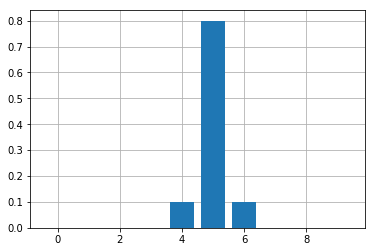

In [6]:
belief = [0., 0., 0., 1., 0., 0., 0., 0., 0., 0.]
simple_assumption_predict(belief=belief)

In the realism, sensor is not perfect, so sometimes will report two or more position. (That is convolution)

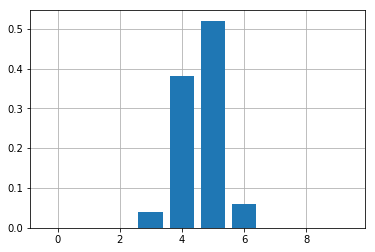

In [7]:
belief = [0., 0., .4, .6, 0., 0., 0., 0., 0., 0.]
simple_assumption_predict(belief=belief)

<IPython.core.display.Javascript object>


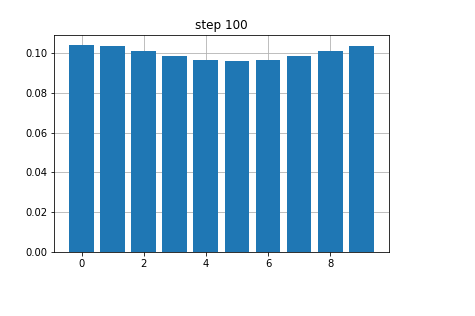

In [8]:
%matplotlib notebook
from time import sleep

belief = np.array([1., 0, 0, 0, 0, 0, 0, 0, 0, 0])
fig, ax = plt.subplots(1, 1)

for i in range(100):
    plt.cla()
    belief = predict_move(belief, 1, .1, .8, .1)
    ax.set_axisbelow(True)
    ax.grid()
    ax.bar(np.arange(10), belief)
    ax.set_title('step {}'.format(i+1))
    plt.gcf().canvas.draw()
    sleep(.1)

%matplotlib inline

### Generalizing Data with Convolution
As aforementioned, I already demonstrate the convolution, and let me dive in more detail.

Convolution is transform two distribution data into one, and we can achieve it by multiply these distributions.

Formula:
$$ (f \ast g) [t] = \sum\limits_{\tau=0}^t \!f[\tau] \, g[t-\tau] $$

Q: How to mutilply these distibutions? Matrix multiplication? <br/>

A: No, convolution multiply these distributions by sliding way. <br/>
Locking one distribution's small period data, kernel, times another distribution to get small period of transforming data. Furthermore, repeat this process through entire data range.

### step by step

In [9]:
def simple_likelihood(hall_way, z, cprob):
    likelihood = np.ones(len(hall_way))
    likelihood[hall_way==z] *= cprob / (1-cprob)
    return likelihood

def simple_update(likelihood, prior):
    uvalue = likelihood * prior
    return uvalue / sum(uvalue)

def simple_conv(pdf, kernel, offset):
    n = len(pdf)
    kw = (len(kernel)-1)/2
    prior = np.zeros(len(pdf))
    for i in range(n):
        for ki in range(len(kernel)):
            index = (i - offset + (kw-ki))%n
            prior[i] += pdf[index] * kernel[ki]
    return prior

def simple_draw(pdf1, pdf2):
    fig, ax = plt.subplots(1, 2, figsize=(20, 5))
    ax[0].set_axisbelow(True)
    ax[0].grid()
    ax[0].bar(np.arange(10), pdf1)
    ax[0].set_title('pdf 1')
    ax[1].set_axisbelow(True)
    ax[1].grid()
    ax[1].bar(np.arange(10), pdf2)
    ax[1].set_title('pdf 2')
    plt.show()

In [10]:
hall_way = np.array([1, 1, 0, 0, 0, 0, 0, 0, 1, 0]).astype(np.float32)
likelihood = simple_likelihood(hall_way, 1, .75)
prior = np.array([.1]*10)

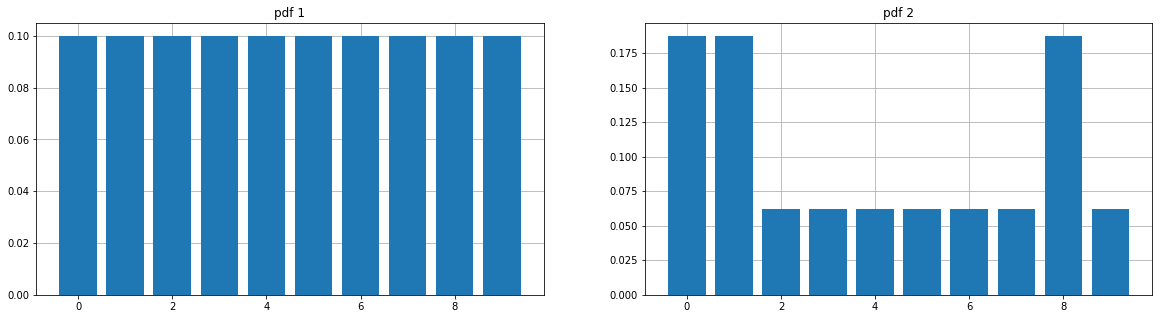

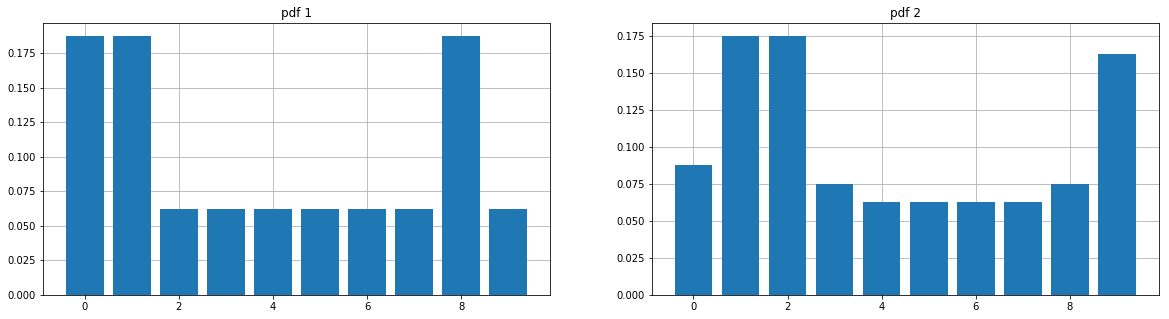

In [11]:
posterio = simple_update(likelihood, prior)
simple_draw(prior, posterio)

kernel = [.1, .8, .1]
prior = simple_conv(posterio, kernel, 1)
simple_draw(posterio, prior)